In [10]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from tqdm import tqdm
import re

In [2]:
orig_meta = pd.read_csv("Five_Actors_Orig_Meta.csv", index_col="imdb_title_id")
new_meta = pd.read_csv("Five_Actors_New_Meta.csv", index_col="imdb_title_id")
income = pd.read_csv("Five_Actors_Income.csv", index_col="imdb_title_id")

orig_meta = orig_meta.drop(columns=["avg_vote", "votes"])
new_meta = new_meta.drop(columns=["avg_vote", "votes"])
income = income.drop(columns=["avg_vote", "votes"])

In [3]:
def normalize_columns(df, column):
    max_duration = df["duration"].abs().max()
    max_budget = df["adjusted_budget"].abs().max()
    max_col = df[column].abs().max()

    df["duration"] = df["duration"] / max_duration
    df["adjusted_budget"] = df["adjusted_budget"] / max_budget
    df[column] = df[column] / max_col
    
    return max_duration, max_budget, max_col, df

In [4]:
orig_max_dur, orig_max_bud, orig_max_meta, norm_orig_meta = normalize_columns(orig_meta, "metascore")
income_max_dur, income_max_bud, income_max_meta, norm_income = normalize_columns(income, "adjusted_gross_income")
norm_income

,duration,adjusted_budget,adjusted_gross_income,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,...,actors_Zsolt Nagy,actors_Zulay Henao,actors_Ángela Molina,actors_Émilie Dequenne,actors_Éric Bougnon,actors_Éric Caravaca,actors_Éric Naggar,actors_Ólafur Darri Ólafsson,actors_Óscar Jaenada,actors_Þorsteinn Bachmann
imdb_title_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,0.367601,0.187322,3.138418e-02,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0042192,0.429907,0.040149,4.564019e-04,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0042208,0.348910,0.035331,9.061415e-05,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0042332,0.230530,0.083166,2.885968e-01,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0042464,0.274143,0.045885,2.036604e-05,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9877340,0.417445,0.001919,1.204128e-05,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt9878242,0.404984,0.001152,3.029538e-05,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt9886872,0.404984,0.001152,7.344196e-07,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
bryce_meta = pd.read_csv("filled_metascores_forest.csv", index_col="imdb_title_id")
new_meta2 = new_meta.copy()
new_meta2["filled_metascore"] = bryce_meta["filled_metascore"]

profit = income.copy()
profit["profit"] = profit["adjusted_gross_income"] - profit["adjusted_budget"]
profit = profit.drop(columns=['adjusted_gross_income'])

ratio = income.copy()
# Some movies were made with no money, so we change those to have a budget of $1
ratio.loc[ratio["adjusted_budget"] == 0] = 1
ratio["profit_margin"] = ratio["adjusted_gross_income"] / ratio["adjusted_budget"]
ratio = ratio.drop(columns=["adjusted_gross_income"])

In [15]:
def linear_regress(df: pd.DataFrame, target_col: str):
    """
    Takes a dataframe and does linear regression on it.

    Parameters:
        df (pd.DataFrame): The dataframe to use
        target_col (str): The name of the column to predict

    Returns:
        Something (the coefficients? The model itself?  Idk)
    """
    # Split into X and y
    Y = df[target_col] # Get the target column
    df = df.drop(columns=[target_col])
    X = sparse.csr_matrix(df.values) # Convert the dataframe to a sparse matrix

    # Train-test split (70-30)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

    # Make the model
    ols = LinearRegression(fit_intercept=True) # Make sure it adds a column  of ones
    
    # Fit the model
    ols.fit(X_train, Y_train)
    
    lasso = Lasso(fit_intercept=True)
    lasso.fit(X_train, Y_train)
    
    elastic = ElasticNet(fit_intercept=True, l1_ratio=.4, selection="random", warm_start=True)
    elastic.fit(X_train, Y_train)
    
    print("Regression score is " + str(ols.score(X_test, Y_test)))
    print("Lasso score is " + str(lasso.score(X_test, Y_test)))
    print("Elastic Net score is " + str(elastic.score(X_test, Y_test)))
    #return ols.coef_, df.columns

In [7]:
def random_forest(X: pd.DataFrame, y: str):
    
    clf = RandomForestRegressor(n_estimators=200, min_samples_split=200, 
                                n_jobs=-1, oob_score=True, warm_start=True)
    clf.fit(X, y)
    print("Random Forest OOB score is " + str(clf.oob_score_))
    
    # Train-test split (70-30)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    bTree = GradientBoostingRegressor(n_estimators=50, loss='squared_error',
                        learning_rate=.3, min_samples_split=20, max_depth=7,
                        min_samples_leaf=3, random_state=42).fit(X_train, y_train)
    print("Boosted Tree score is " + str(bTree.score(X_test, y_test)))
    
    return bTree, bTree.feature_importances_

In [8]:
def get_scores(scores, columns):

    genres = []
    directors = []
    writers = []
    productions = []
    actors = []

    genre_pattern = re.compile(r"(genre_)(.*)")
    director_pattern = re.compile(r"(director_)(.*)")
    writer_pattern = re.compile(r"(writer_)(.*)")
    production_pattern = re.compile(r"(production_company_)(.*)")
    actor_pattern = re.compile(r"(actors_)(.*)")

    # create lists of the different genres, directors, writers, production companies, and actors
    for i in range(len(columns)):
        if bool(genre_pattern.search(columns[i])) == True:
            genre_line = genre_pattern.findall(columns[i])
            genres.append(genre_line[0][1])
        if bool(director_pattern.search(columns[i])) == True:
            director_line = director_pattern.findall(columns[i])
            directors.append(director_line[0][1])
        if bool(writer_pattern.search(columns[i])) == True:
            writer_line = writer_pattern.findall(columns[i])
            writers.append(writer_line[0][1])
        if bool(production_pattern.search(columns[i])) == True:
            production_line = production_pattern.findall(columns[i])
            productions.append(production_line[0][1])
        if bool(actor_pattern.search(columns[i])) == True:
            actor_line = actor_pattern.findall(columns[i])
            actors.append(actor_line[0][1])

    genre_scores = []
    director_scores = []
    writer_scores = []
    production_scores = []
    actor_scores = []

    # create lists of the different genre, director, writer, production company, and actor scores
    for i in range(len(columns)):
        if "genre_" in columns[i]:
            genre_scores.append(scores[i])
        if "director_" in columns[i]:
            director_scores.append(scores[i])
        if "writer_" in columns[i]:
            writer_scores.append(scores[i])
        if "production_company_" in columns[i]:
            production_scores.append(scores[i])
        if "actors_" in columns[i]:
            actor_scores.append(scores[i])

    # function to return the names of the n highest scores of a category
    def get_highest_scoring(how_many, names, scores):

        top_names = []

        # we are looking at the absolute values of the scores
        indices = (-np.abs(scores)).argsort()
        highest_score_indices = indices[:how_many]

        for index in highest_score_indices:
            top_names.append(names[index])

        return top_names

    # find names of highest scores of each categorical feature
    highest_genres = get_highest_scoring(2, genres, genre_scores)
    highest_directors = get_highest_scoring(1, directors, director_scores)
    highest_writers = get_highest_scoring(2, writers, writer_scores)
    highest_productions = get_highest_scoring(1, productions, production_scores)
    highest_actors = get_highest_scoring(7, actors, actor_scores)


    # This is a function to grab the score of a specific column
    def get_column_score(columns, scores, column_name):

        for i in range(len(columns)):
            if columns[i] == column_name:
                return scores[i]

    return highest_genres, highest_directors, highest_writers, highest_productions, highest_actors

In [9]:
def get_duration_budget(df, genres, directors, writers, productions, actors):
    fig, axs = plt.subplots(3, 4, figsize = (12, 9))
    axs = axs.flatten()
    
    genre_durations = df.loc[np.any(df[[f"genre_{genre}" for genre in genres]] == 1, axis=1), "duration"]
    axs[0].hist(genre_durations, bins=50)
    axs[0].set_title("Genre Duration")
    
    director_durations = df.loc[np.any(df[[f"director_{director}" for director in directors]] == 1, axis=1), "duration"]
    axs[1].hist(director_durations, bins=50)
    axs[1].set_title("Director Duration")
    
    writer_durations = df.loc[np.any(df[[f"writer_{writer}" for writer in writers]] == 1, axis=1), "duration"]
    axs[2].hist(writer_durations, bins=50)
    axs[2].set_title("Writer Duration")
    
    production_durations = df.loc[np.any(df[[f"production_company_{production}" for production in productions]] == 1, axis=1), "duration"]
    axs[3].hist(production_durations, bins=50)
    axs[3].set_title("Production Duration")
    
    actor_durations = df.loc[np.any(df[[f"actors_{actor}" for actor in actors]] == 1, axis=1), "duration"]
    axs[4].hist(actor_durations, bins=50)
    axs[4].set_title("Actor Duration")
        
    genre_budgets = df.loc[np.any(df[[f"genre_{genre}" for genre in genres]] == 1, axis=1), "adjusted_budget"]
    axs[5].hist(genre_budgets, bins=50)
    axs[5].set_title("Genre Budget")
    
    director_budgets = df.loc[np.any(df[[f"director_{director}" for director in directors]] == 1, axis=1), "adjusted_budget"]
    axs[6].hist(director_budgets, bins=50)
    axs[6].set_title("Director Budget")
    
    writer_budgets = df.loc[np.any(df[[f"writer_{writer}" for writer in writers]] == 1, axis=1), "adjusted_budget"]
    axs[7].hist(writer_budgets, bins=50)
    axs[7].set_title("Writer Budget")
    
    production_budgets = df.loc[np.any(df[[f"production_company_{production}" for production in productions]] == 1, axis=1), "adjusted_budget"]
    axs[8].hist(production_budgets, bins=50)
    axs[8].set_title("Production Budget")
    
    actor_budgets = df.loc[np.any(df[[f"actors_{actor}" for actor in actors]] == 1, axis=1), "adjusted_budget"]
    axs[9].hist(actor_budgets, bins=50)
    axs[9].set_title("Actor Budget")
            
    overall_mask = np.any(df[[f"director_{director}" for director in directors] +
                   [f"writer_{writer}" for writer in writers] + 
                   [f"production_company_{production}" for production in productions] + 
                   [f"actors_{actor}" for actor in actors]] == 1, axis = 1) & \
                   np.any(df[[f"genre_{genre}" for genre in genres]] == 1, axis=1)
    
    overall_duration = df.loc[overall_mask, "duration"]
    overall_budget = df.loc[overall_mask, "adjusted_budget"]
    axs[10].hist(overall_duration, bins=50)
    axs[10].set_title("Overall Duration")
    axs[11].hist(overall_budget, bins=50)
    axs[11].set_title("Overall Budget")
    
    fig.tight_layout()

    return np.mean(overall_duration), np.mean(overall_budget)

Random Forest OOB score is 0.5027527651539428
Boosted Tree score is 0.5447733352609736
Regression score is -1.331420845635685
Lasso score is -0.0001259404805746822
Elastic Net score is -0.0001259404805746822
['Adventure', 'Drama']
['Steven Spielberg']
['George Lucas', 'Andrew Stanton']
['Lucasfilm']
['Ben Wright', 'Anthony Daniels', 'Josh Gad', 'Julie Andrews', 'Jeff Goldblum', 'Mark Hamill', 'Murray Hamilton']
Duration = 0.3672839506172839
Budget = 0.24102020942475294


C:\Users\torgo\Anaconda3\lib\site-packages\sklearn\base.py:435: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


adjusted_gross_income prediction is 0.7192037432818386


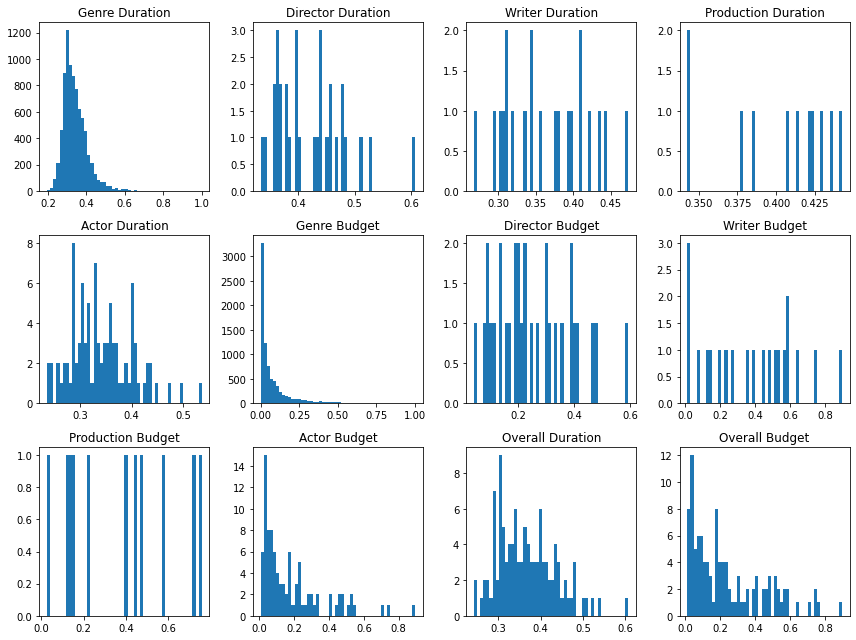

In [16]:
target_col = "adjusted_gross_income"
df = norm_income

temp_data = df

# Split into X and y
y = temp_data[target_col] # Get the target column
temp_data = temp_data.drop(columns=[target_col])

# Convert the dataframe to a sparse matrix
X = sparse.csr_matrix(temp_data.values)

# random_forest and linear_regress will show how well they fit the data
# and random_forest returns a boosted tree and its feature importance
tree, feature_importance = random_forest(X, y)
linear_regress(df, target_col)

# Find what the genres, directors, writers, production companies, and actors should be
genres, directors, writers, productions, actors = get_scores(feature_importance, temp_data.columns)
print(genres)
print(directors)
print(writers)
print(productions)
print(actors)

# Find what the duration and budget should be
duration, budget = get_duration_budget(df, genres, directors, writers, productions, actors)

print("Duration = " + str(duration))
print("Budget = " + str(budget))

# create a movie with the attributes suggested by the boosted tree
movie = np.zeros_like(df.iloc[0])
movie = pd.DataFrame([movie], columns=df.columns)

movie["adjusted_budget"] = budget
movie["duration"] = duration
movie.loc[:,[f"genre_{genre}" for genre in genres]] = 1
movie.loc[:,[f"director_{director}" for director in directors]] = 1
movie.loc[:,[f"writer_{writer}" for writer in writers]] = 1
movie.loc[:,[f"production_company_{production}" for production in productions]] = 1
movie.loc[:,[f"actors_{actor}" for actor in actors]] = 1

movie = movie.drop(columns=[target_col])

# print the predicted value of the movie with the boosted tree
print(str(target_col) + " prediction is " + str(tree.predict(movie)[0]))